## Prepare the text for LDA Analysis 
To convert it into a format that is used as an input for training the LDA model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

sns.set_style('whitegrid')

In [3]:
df = pd.read_csv('E:/NewsFMCG/FMCGNewsTopic(2).csv', encoding='latin1') 
                 #names=['Date', 'URL', 'Newspaper', 'Title', 'Article', 'Day', 'Month', 'ArticleLength'])
df.shape

(449, 10)

In [4]:
df.drop(['Date', 'URL', 'Newspaper', 'Title', 'Article', 'Day', 'Month','ArticleFinal','WordCount'],axis=1,inplace=True)

In [ ]:
import re

remove = ['state']

def clean_text(txt_lower):
    tokens = re.split('\W+', txt_lower)
    txt_lower = ' '.join([word for word in tokens if word not in remove])
    return(txt_lower)

df['ArticleFinal_replaceWord'] = df['ArticleFinal_replaceWord'].map(lambda x: clean_text(x))

In [5]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer

## Exploratory Data Analysis
To verify whether the pre-processing happened correctly

We’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

In [6]:
# Import the wordcloud library
# conda install -c conda-forge wordcloud
from wordcloud import WordCloud

In [7]:
long_string = ','.join(list(df['ArticleFinal_replaceWord'].values))

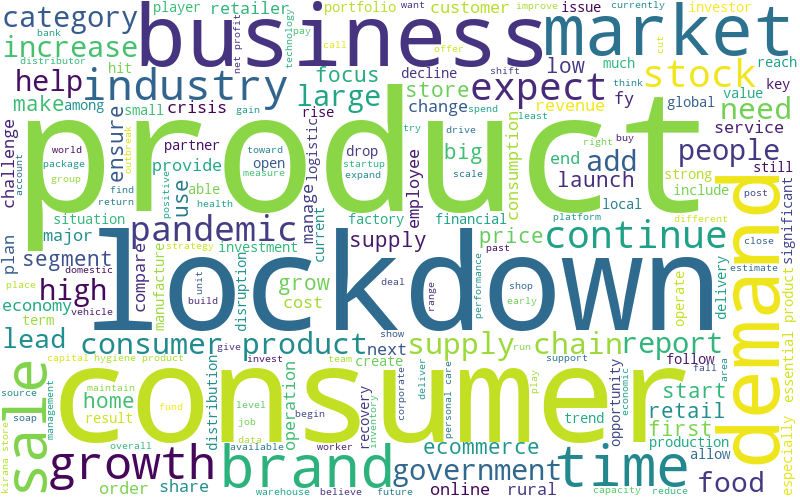

In [45]:
# New
# After dropping additional stopwords
long_string = ','.join(list(df['ArticleFinal_replaceWord'].values))
len(long_string)
# Join the different processed articles together.
#long_string = ','.join(list(df['Article_clean'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=200, contour_width=3, 
                      contour_color='steelblue', width=800, height=400)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# Collocations and N-grams
Collocations are just frequent bigrams that unusually occur together in text

In [9]:
#set(bigrams(long_string_list))
#long_string.collocations()

from nltk import bigrams, trigrams

In [11]:
#long_string = ' '.join(list(df['ArticleFinal'].values))
unigrams = nltk.word_tokenize(long_string)
bigrams = bigrams(unigrams)
trigrams = trigrams(unigrams)

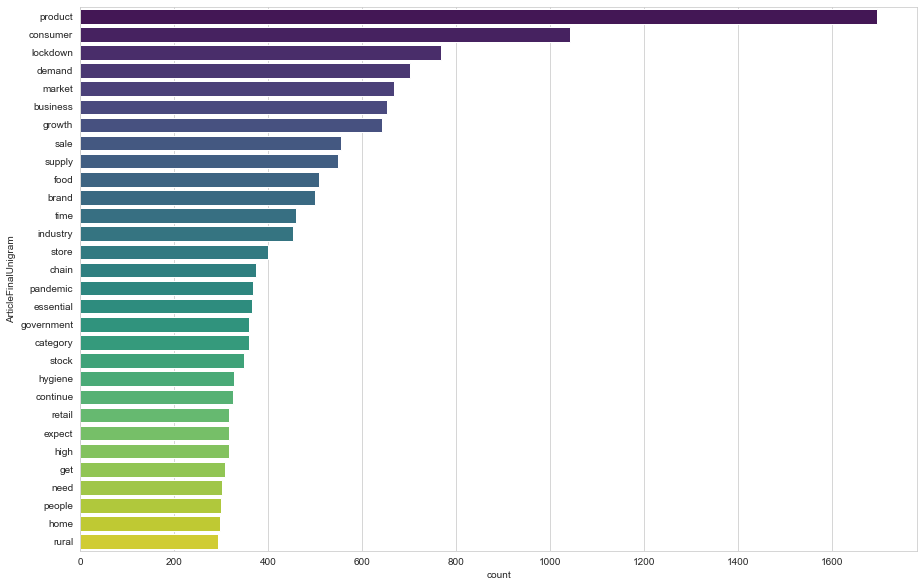

In [12]:
# New
def get_top_n_words(corpus, n=None):
    count_vectorizer = CountVectorizer(ngram_range=(1, 1))
    vec = count_vectorizer.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['ArticleFinal_replaceWord'], 50)
#for word, freq in common_words:
    #print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['ArticleFinalUnigram' , 'count'])
ser2 = df2.groupby('ArticleFinalUnigram').sum()['count'].sort_values(ascending=False)
ax = plt.figure(figsize=(15,10))
ax = sns.barplot(x='count',y='ArticleFinalUnigram',data=df2[:30],palette='viridis');
#ax.set_yticklabels(ser2.index,rotation=0);

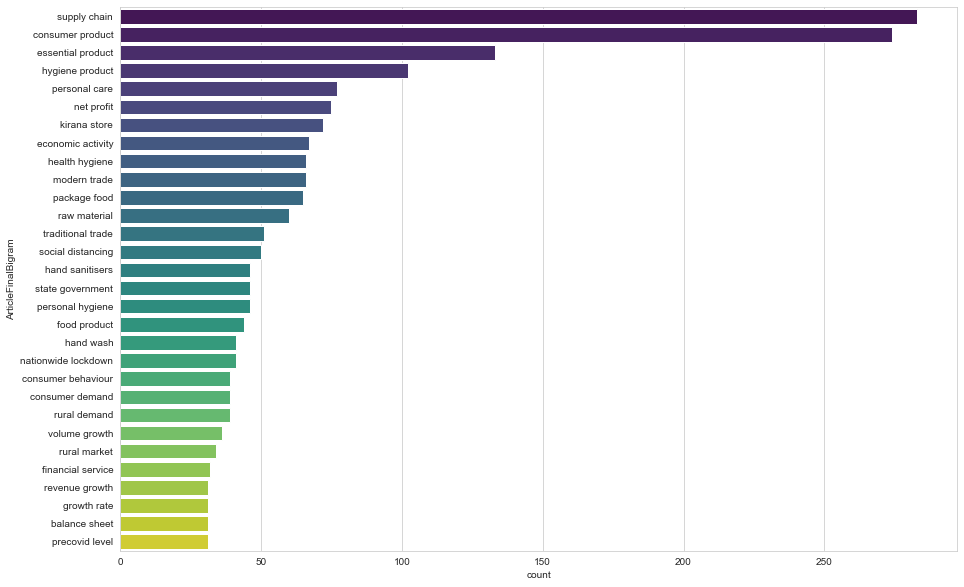

In [13]:
# New
def get_top_n_words(corpus, n=None):
    count_vectorizer = CountVectorizer(ngram_range=(2, 2))
    vec = count_vectorizer.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['ArticleFinal_replaceWord'], 50)
#for word, freq in common_words:
    #print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['ArticleFinalBigram' , 'count'])
ser2 = df2.groupby('ArticleFinalBigram').sum()['count'].sort_values(ascending=False)
ax = plt.figure(figsize=(15,10))
ax = sns.barplot(x='count',y='ArticleFinalBigram',data=df2[:30],palette='viridis');
#ax.set_yticklabels(ser2.index,rotation=0);

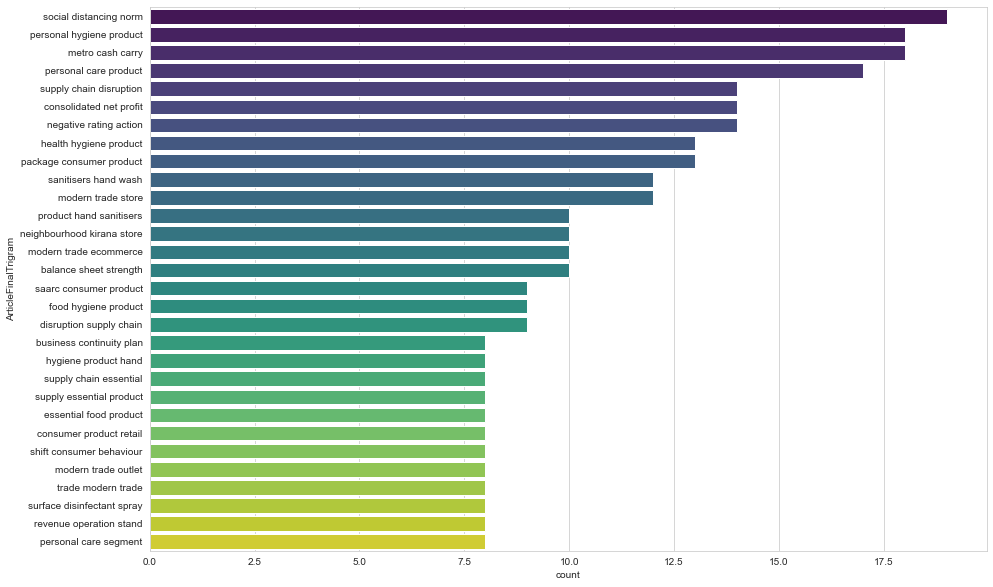

In [14]:
# New
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['ArticleFinal_replaceWord'], 30)
#for word, freq in common_words:
    #print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['ArticleFinalTrigram' , 'count'])
ser3 = df3.groupby('ArticleFinalTrigram').sum()['count'].sort_values(ascending=False)
ax = plt.figure(figsize=(15,10))
ax = sns.barplot(x='count',y='ArticleFinalTrigram',data=df3,palette='viridis');

In [8]:
df.to_csv(r'E:\NewsFMCG\FMCGNewsTopic(2).csv',index=False)

# Evaluate Topic Models: Latent Dirichlet Allocation (LDA)

**Preparing Text for LDA Analysis**

In [27]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer()
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['ArticleFinal_replaceWord'])

In [7]:
df['WordCount'] = df['ArticleFinal_replaceWord'].apply(lambda x: len(str(x).split()))
df['WordCount'].max()

1301

In [53]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [11]:
# Import required packages
import re
import numpy as np
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import pyLDAvis.gensim
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

from nltk.tokenize import RegexpTokenizer
from gensim import corpora

In [55]:
import os.path

In [28]:
# Covert to array
docs = array(df['ArticleFinal_replaceWord'])
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

In [9]:
docs

array([list(['either', 'ramp', 'production', 'double', 'distribution', 'effort', 'ensure', 'availability', 'hygiene', 'product', 'handwash', 'hand', 'sanitisers', 'retail', 'shelf', 'meet', 'massive', 'spike', 'demand', 'begin', 'report', 'increase', 'coronavirus', 'casesconsumers', 'certain', 'region', 'social', 'medium', 'report', 'shortage', 'product', 'hand', 'sanitisers', 'key', 'player', 'wednesday', 'state', 'adequate', 'stock', 'available', 'productscreating', 'awarenesssunil', 'saarc', 'consumer', 'product', 'ramp', 'production', 'protekt', 'hand', 'wash', 'sanitisers', 'unit', 'vendor', 'partner', 'unit', 'start', 'strong', 'digital', 'campaign', 'protekt', 'create', 'awareness', 'regime', 'wash', 'hand', 'regularly', 'help', 'prevent', 'virus', 'intent', 'campaign', 'educate', 'consumer', 'prevention', 'covida', 'spokesperson', 'adequate', 'stock', 'hand', 'sanitisers', 'meet', 'spike', 'demand', 'surge', 'demand', 'hygiene', 'product', 'redouble', 'effort', 'ensure', 'consu

In [29]:
# Create dictionary
dictn = corpora.Dictionary(docs)
len(dictn)

2020-10-26 20:33:10,225 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-10-26 20:33:10,504 : INFO : built Dictionary(14170 unique tokens: ['able', 'access', 'add', 'addedcompanies', 'address']...) from 449 documents (total 111032 corpus positions)


14170

In [11]:
# Show the word to id map
print(dictn.token2id)
# Successfully ccreated a dictionary
# Gensim uses this dictionary to create a bag of words corpus
# In which the words in the documents will be replaced by their respective ids provided by 
# this dictionary

{'able': 0, 'access': 1, 'add': 2, 'addedcompanies': 3, 'address': 4, 'adequate': 5, 'advantage': 6, 'alongside': 7, 'appropriate': 8, 'association': 9, 'availability': 10, 'available': 11, 'awareness': 12, 'awarenesssunil': 13, 'away': 14, 'ayurvedic': 15, 'battle': 16, 'begin': 17, 'believe': 18, 'besides': 19, 'big': 20, 'campaign': 21, 'casesconsumers': 22, 'caution': 23, 'certain': 24, 'ch': 25, 'child': 26, 'clear': 27, 'consumer': 28, 'continue': 29, 'corona': 30, 'coronavirus': 31, 'country': 32, 'countrywide': 33, 'covida': 34, 'create': 35, 'demand': 36, 'digital': 37, 'distribution': 38, 'distributor': 39, 'doctor': 40, 'double': 41, 'drug': 42, 'educate': 43, 'effort': 44, 'either': 45, 'enhance': 46, 'ensure': 47, 'face': 48, 'family': 49, 'federation': 50, 'focus': 51, 'gear': 52, 'globe': 53, 'govt': 54, 'hand': 55, 'handwash': 56, 'handwashing': 57, 'haydon': 58, 'headhealthcare': 59, 'help': 60, 'high': 61, 'hike': 62, 'himalaya': 63, 'however': 64, 'hygiene': 65, 'inc

Thus, the dictionary obtained has 14,221 unique tokens each assigned its own unique id.

In [30]:
# Creating a bag of words corpus using the dictionary
# Object that contains the word_id and its frequency for each document in the original corpus
# Gensim's equivalent of a document-term term matrix
my_corpus = [dictn.doc2bow(doc) for doc in docs]
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

2020-10-26 20:33:15,664 : INFO : collecting all words and their counts
2020-10-26 20:33:15,666 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-10-26 20:33:16,126 : INFO : collected 98790 word types from a corpus of 111032 words (unigram + bigrams) and 449 sentences
2020-10-26 20:33:16,128 : INFO : using 98790 counts as vocab in Phrases<0 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>
2020-10-26 20:33:16,137 : INFO : collecting all words and their counts
2020-10-26 20:33:16,141 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-10-26 20:33:17,532 : INFO : collected 100187 word types from a corpus of 106800 words (unigram + bigrams) and 449 sentences
2020-10-26 20:33:17,533 : INFO : using 100187 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


In [13]:
my_corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 2),
  (5, 4),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 5),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 2),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 4),
  (22, 1),
  (23, 1),
  (24, 2),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 6),
  (29, 1),
  (30, 1),
  (31, 4),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 9),
  (37, 4),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 3),
  (44, 3),
  (45, 1),
  (46, 1),
  (47, 3),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 13),
  (56, 2),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 2),
  (61, 1),
  (62, 2),
  (63, 1),
  (64, 1),
  (65, 5),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 5),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 2),
  (82, 1),
  (83, 2),
  (84, 2),
  (85, 6),
  (86, 4),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 1

[tfidf Reference Video](https://www.youtube.com/watch?v=SsFxy2bxpZU)

In [31]:
# Model
from gensim import models
# Train the model 
tfidf = models.TfidfModel(my_corpus)
# Transform the system minors

2020-10-26 20:33:20,579 : INFO : collecting document frequencies
2020-10-26 20:33:20,582 : INFO : PROGRESS: processing document #0
2020-10-26 20:33:20,620 : INFO : calculating IDF weights for 449 documents and 14170 features (76209 matrix non-zeros)


In [32]:
tfidf_corpus = tfidf[my_corpus]

In [33]:
# Training the LDA model
lda_model = LdaModel(corpus = tfidf_corpus,
                    id2word=dictn,
                    num_topics=7,
                    random_state=0,
                    passes=10,
                    alpha='auto',
                    per_word_topics=True)

2020-10-26 20:33:25,743 : INFO : using autotuned alpha, starting with [0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715]
2020-10-26 20:33:25,745 : INFO : using symmetric eta at 0.14285714285714285
2020-10-26 20:33:25,752 : INFO : using serial LDA version on this node
2020-10-26 20:33:25,782 : INFO : running online (multi-pass) LDA training, 7 topics, 10 passes over the supplied corpus of 449 documents, updating model once every 449 documents, evaluating perplexity every 449 documents, iterating 50x with a convergence threshold of 0.001000
2020-10-26 20:33:28,185 : INFO : -29.354 per-word bound, 686253311.2 perplexity estimate based on a held-out corpus of 449 documents with 4605 words
2020-10-26 20:33:28,188 : INFO : PROGRESS: pass 0, at document #449/449
2020-10-26 20:33:29,066 : INFO : optimized alpha [0.11001356, 0.10806106, 0.104697086, 0.11000168, 0.10670153, 0.115638435, 0.12192959]
2020-10-26 20:33:29,100 : INFO : topic #2 (0.105): 0.001*"rural"

In [34]:
## View the topics in LDA model
#lda_model.print_topics(-1)
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[tfidf_corpus]

2020-10-26 20:33:50,938 : INFO : topic #0 (0.065): 0.000*"job" + 0.000*"hire" + 0.000*"patanjali" + 0.000*"layoff" + 0.000*"expat" + 0.000*"mediker" + 0.000*"fmcgd" + 0.000*"search" + 0.000*"cxo" + 0.000*"creation"
2020-10-26 20:33:50,942 : INFO : topic #1 (0.064): 0.001*"walmart" + 0.000*"avail" + 0.000*"moratorium" + 0.000*"crisil" + 0.000*"vilcart" + 0.000*"boonbox" + 0.000*"truck" + 0.000*"gift" + 0.000*"nearstore" + 0.000*"rat"
2020-10-26 20:33:50,947 : INFO : topic #2 (0.059): 0.000*"hot" + 0.000*"cobots" + 0.000*"warehouse" + 0.000*"multicorp" + 0.000*"sq" + 0.000*"concor" + 0.000*"nonmetros" + 0.000*"ft" + 0.000*"cg" + 0.000*"robot"
2020-10-26 20:33:50,949 : INFO : topic #3 (0.063): 0.000*"flavour" + 0.000*"fiis" + 0.000*"fragrance" + 0.000*"iip" + 0.000*"fafai" + 0.000*"churna" + 0.000*"litre" + 0.000*"investigation" + 0.000*"burman" + 0.000*"aashirvaad"
2020-10-26 20:33:50,952 : INFO : topic #4 (0.063): 0.000*"swab" + 0.000*"bread" + 0.000*"baby" + 0.000*"beardo" + 0.000*"tal

[(0, '0.000*"job" + 0.000*"hire" + 0.000*"patanjali" + 0.000*"layoff" + 0.000*"expat" + 0.000*"mediker" + 0.000*"fmcgd" + 0.000*"search" + 0.000*"cxo" + 0.000*"creation"'), (1, '0.001*"walmart" + 0.000*"avail" + 0.000*"moratorium" + 0.000*"crisil" + 0.000*"vilcart" + 0.000*"boonbox" + 0.000*"truck" + 0.000*"gift" + 0.000*"nearstore" + 0.000*"rat"'), (2, '0.000*"hot" + 0.000*"cobots" + 0.000*"warehouse" + 0.000*"multicorp" + 0.000*"sq" + 0.000*"concor" + 0.000*"nonmetros" + 0.000*"ft" + 0.000*"cg" + 0.000*"robot"'), (3, '0.000*"flavour" + 0.000*"fiis" + 0.000*"fragrance" + 0.000*"iip" + 0.000*"fafai" + 0.000*"churna" + 0.000*"litre" + 0.000*"investigation" + 0.000*"burman" + 0.000*"aashirvaad"'), (4, '0.000*"swab" + 0.000*"bread" + 0.000*"baby" + 0.000*"beardo" + 0.000*"talent" + 0.000*"antique" + 0.000*"unicef" + 0.000*"asi" + 0.000*"pg" + 0.000*"ayurvedic"'), (5, '0.001*"avenue" + 0.001*"supermarts" + 0.001*"lifebuoy" + 0.000*"dmart" + 0.000*"crisil" + 0.000*"biyani" + 0.000*"ipl" + 0

#### TUNE TOPIC MODELS FOR OPTIMAL NUMBER OF TOPICS
OBJECTIVE: To extract good quality of topics that are clear, segregated and meaningful

[Text pre-processing and the strategy to find the optimal number of topics](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

'alpha' and 'eta' are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both default to 1.0/num_topics prior.

In [20]:
from gensim.models import CoherenceModel

In [35]:
# Computing Model Perplexity and Coherence Score
# Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(tfidf_corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictn, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2020-10-26 20:33:53,807 : INFO : -11.382 per-word bound, 2668.4 perplexity estimate based on a held-out corpus of 449 documents with 4605 words
2020-10-26 20:33:53,825 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows



Perplexity:  -11.381760021487537


2020-10-26 20:34:24,696 : INFO : 1 batches submitted to accumulate stats from 64 documents (7914 virtual)
2020-10-26 20:34:24,707 : INFO : 2 batches submitted to accumulate stats from 128 documents (17766 virtual)
2020-10-26 20:34:24,721 : INFO : 3 batches submitted to accumulate stats from 192 documents (27538 virtual)
2020-10-26 20:34:24,737 : INFO : 4 batches submitted to accumulate stats from 256 documents (36245 virtual)
2020-10-26 20:34:24,767 : INFO : 5 batches submitted to accumulate stats from 320 documents (46371 virtual)
2020-10-26 20:34:24,785 : INFO : 6 batches submitted to accumulate stats from 384 documents (55018 virtual)
2020-10-26 20:34:24,798 : INFO : 7 batches submitted to accumulate stats from 448 documents (61904 virtual)
2020-10-26 20:34:25,667 : INFO : 7 accumulators retrieved from output queue
2020-10-26 20:34:25,714 : INFO : accumulated word occurrence stats for 63615 virtual documents



Coherence Score:  0.6174842353440522


### Visualize the topics-keywords

In [36]:
import pyLDAvis.gensim

In [37]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, tfidf_corpus, dictn, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.015728  0.003827       1        1   2.722185
1      0.017125  0.000103       2        1   2.888227
2      0.018170 -0.000461       3        1   2.071856
3      0.017510  0.001257       4        1   2.701731
4      0.017261  0.001958       5        1   2.553641
5      0.008442 -0.007200       6        1   4.321693
6     -0.094236  0.000516       7        1  82.740669, topic_info=            Term      Freq     Total Category  logprob  loglift
237    warehouse  2.000000  2.000000  Default  30.0000  30.0000
345          job  2.000000  2.000000  Default  29.0000  29.0000
1890       truck  1.000000  1.000000  Default  28.0000  28.0000
272         hire  1.000000  1.000000  Default  27.0000  27.0000
761   moratorium  0.000000  0.000000  Default  26.0000  26.0000
...          ...       ...       ...      ...      ...      ...
676      revenue  4.337996  4.434424   Topic7  -6.7782   0.1675
53          hand  3.962559  4.047544   Topic7  -6.8688   0.1682
755     lockdown  3.646276  3.722330   Topic7  -6.9519   0.1688
187       expect  3.636084  3.711979   Topic7  -6.9547   0.1688
122       retail  3.733455  3.826695   Topic7  -6.9283   0.1648

[322 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1490      7  0.740185     agency
1199      7  0.939445      brand
168       7  0.879187   business
21        7  1.049624   campaign
836       7  0.955016   category
...     ...       ...        ...
546       7  0.869219  transport
1890      7  0.660505      truck
805       7  0.935811      value
3016      7  0.840826    village
237       7  0.972070  warehouse

[68 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])

### Finding the Optimal number of topics

In [18]:
import gensim

In [77]:
from gensim.models.wrappers import LdaMallet

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictn, random_state=0,
                    passes=10,
                    alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictn, corpus=tfidf_corpus, texts=docs, start=2, limit=30, step=5)

2020-10-26 00:20:26,519 : INFO : using autotuned alpha, starting with [0.5, 0.5]
2020-10-26 00:20:26,519 : INFO : using symmetric eta at 0.5
2020-10-26 00:20:26,528 : INFO : using serial LDA version on this node
2020-10-26 00:20:26,533 : INFO : running online (multi-pass) LDA training, 2 topics, 10 passes over the supplied corpus of 449 documents, updating model once every 449 documents, evaluating perplexity every 449 documents, iterating 50x with a convergence threshold of 0.001000
2020-10-26 00:20:28,780 : INFO : -11.784 per-word bound, 3527.2 perplexity estimate based on a held-out corpus of 449 documents with 4605 words
2020-10-26 00:20:28,780 : INFO : PROGRESS: pass 0, at document #449/449
2020-10-26 00:20:29,688 : INFO : optimized alpha [0.8562008, 0.8486242]
2020-10-26 00:20:29,696 : INFO : topic #0 (0.856): 0.001*"rural" + 0.000*"brand" + 0.000*"store" + 0.000*"sale" + 0.000*"business" + 0.000*"growth" + 0.000*"stock" + 0.000*"hygiene" + 0.000*"food" + 0.000*"essential"
2020-1

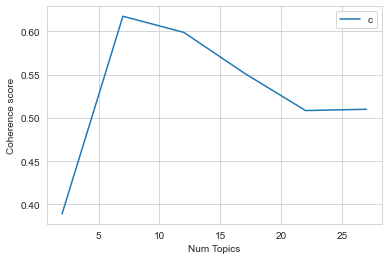

In [26]:
# Show graph
# tf - idf input to LDA
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
text.dispersion_plot([''])